## 야놀자 홈페이지의 호텔 리뷰를 요약하는 모델을 만들고 성능을 향상시킨 후 평가해보자!

### API키 및 기본 설정

In [1]:
import os
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from getpass import getpass

In [2]:
MY_API_KEY = getpass("OpenAI API Key:")

OpenAI API Key: ········


In [3]:
client = OpenAI(api_key=MY_API_KEY)

### 데이터 수집
- 야놀자 홈페이지의 호텔/리조트 탭에서 '신라스테이 역삼' 호텔에 대한 리뷰를 최근순으로 20 스크롤정도 크롤링한 데이터 활용

### 데이터 전처리
- JSON 형태에서 리뷰를 구분할 수 있는 문자열로 만들기

In [10]:
with open('data/ya_review_sinla.json', 'r', encoding='utf-8') as f :
    # json.load : JSON 데이터 불러오기 
    review_list = json.load(f)

print(len(review_list))
review_list[:10]

420


[{'review': '고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.',
  'stars': 5,
  'date': '2024.06.03'},
 {'review': '커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!!', 'stars': 5, 'date': '2022.11.20'},
 {'review': '잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다',
  'stars': 5,
  'date': '2022.10.17'},
 {'review': '조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요',
  'stars': 5,
  'date': '1일 전'},
 {'review': '가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요',
  'stars': 5,
  'date': '3일 전'},
 {'review': '프론트 직원분들이 친절하셔서 좋아요', 'stars': 5, 'date': '3일 전'},
 {'review': '아주좋아요오오옹오ㅗ옹', 'stars': 5, 'date': '2024.10.08'},
 {'review': '청결하고 좋습니다 특히 조식이 맛있었어요', 'stars': 5, 'date': '2024.10.08'},
 {'review': '깨끗

#### 야놀자 리뷰 요약은 GPT-4-turbo 모델로 진행했고, 높은 평점은 5점으로 정의

In [12]:
# 평점 평균 및 분포 확인
stars_list = [i['stars'] for i in review_list]
np.mean(stars_list)

4.754761904761905

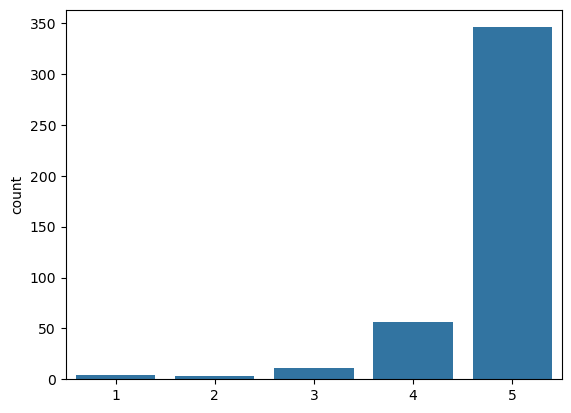

In [14]:
# 점수별 데이터 개수
sns.countplot(x=stars_list);

In [15]:
reviews_high, reviews_low = [], []

for i in review_list :
    if i['stars'] == 5 :
        # LLM이 더 잘 질의를 이해할 수 있도록 리뷰의 시작과 끝을 구분해서 기호로 넣어줌
        reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
    else : 
        reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

print(reviews_high[:3])

['[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]', '[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]', '[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]']


In [16]:
# 프롬프트에 문자열로 넣어줘야하기 때문에 리스트의 리뷰들을 하나의 문자열로 합쳐기기
review_high_text = '\n'.join(reviews_high)
review_low_text = '\n'.join(reviews_low)

print(review_high_text[:500])

[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]
[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]
[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요
여자친구 몰래 프로포즈를 준비하게되었는데
프론트 체크인 도와주셨던 직원분께 양해를 구하고
선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요
바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분
다음번 방문때 감사인사 드리겠습니다
훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]
[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페


#### 각 전처리 단계를 하나의 함수로 작성
- 야놀자 홈페이지의 후기 요약 기간이 최근 6개월 이므로 동일한 조건으로 데이터를 가공

In [17]:
# datetime : 날짜와 시간을 다루는 모듈
import datetime
# dateutil : 다양한 형식의 날짜와 시간 문자열을 파싱하고 시간대 정보를 처리하는 모듈
 # parser : 문자열에서 날짜와 시간 정보를 자동으로 인식하고 추출하는 함수
from dateutil import parser

In [19]:
# 6개월 전 날짜 및 일시 구하기
# datetime.now() : 현재 년월일시분초
# timedelta() : 두 날짜 또는 시간간의 차이를 나타내는 함수
 # 매개변수는 weeks, days, hours, minutes, seconds가 있음
datetime.datetime.now() - datetime.timedelta(weeks=24)

datetime.datetime(2024, 8, 21, 11, 50, 48, 5950)

In [22]:
# 리뷰 전처리 함수
def preprocessing_reviews(path='data/ya_review_sinla.json') :
    with open(path, 'r', encoding='utf-8') as f :
        review_list = json.load(f)

    reviews_high, reviews_low = [], []

    # 현재 날짜(년월일시분초)
    current_date = datetime.datetime.now()

    # 6개월 전 날짜
    date_boundary = current_date - datetime.timedelta(weeks=24)

    for i in review_list : 
        # 리뷰의 날짜 문자열을 변수에 저장
        review_date_str = i['date']
        try :
            # parse : 문자열이 들어오면 코드 형태(날짜타입)으로 변환시켜주는 함수
            review_date = parser.parse(review_date_str)
            
        # 년월일로 표시되지 않은 값들을 처리
        except (ValueError, TypeError) :
            # ~일 전 같은 텍스트는 어차피 7일을 넘어가지 않으므로 6개월 내에 포함되는 리뷰가 됨(오늘날짜로 지정)
            review_date = current_date

        # 해당 리뷰의 날짜가 6개월전 날짜보다 작다면(이전이라면!) 그냥 넘어감
        if review_date < date_boundary :
            continue

        # 별점이 5점인 경우와 아닌 경우 판단(우리는 5점인 경우만 사용할 예정!)
        if i['stars'] == 5 :
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
        else : 
            reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

    # 리스트에 있는 리뷰들을 하나의 문자열로 합쳐주기
    review_high_text = '\n'.join(reviews_high)
    review_low_text = '\n'.join(reviews_low)

    # return은 두 가지로 반환하지만 우리는 review_high_text만 사용 예정!
    return review_high_text, review_low_text

### 리뷰 문장 요약을 위한 Baseline 모델 개발
- base모델(gpt-3.5-turbo)이 야놀자 후기 요약 문장(gpt-4-turbo 모델 사용)에 근접하게 성능을 향상시켜 보는 것이 우리의 목표!!

In [23]:
# _ 는 해당 위치의 반환값을 사용하지 않겠다는 뜻
reviews, _ = preprocessing_reviews()

In [25]:
PROMPT_BASELINE = "아래 숙소 리뷰에 대해 5문장 내로 요약해줘: "

In [26]:
# LLM을 호출하여 리뷰들에 대한 요약을 진행하는 사용자 정의 함수 선언
def summarize(reviews, prompt, temperature=0, model='gpt-3.5-turbo') :
    prompt = prompt + '\n\n' + reviews

    completion = client.chat.completions.create(model = model,
                                                messages = [{'role':'user', 'content':prompt}],
                                                temperature = temperature
                                               )
    return completion

#### 모델별 요약 결과

In [27]:
# gpt-3.5-turbo
print(summarize(reviews, PROMPT_BASELINE, model='gpt-3.5-turbo').choices[0].message.content)

다양하고 맛있는 조식과 할인 혜택이 좋았고, 직원들의 친절한 대응이 인상적이었습니다. 위치와 시설이 좋아서 가족들이 만족해했고, 깨끗하고 친절한 서비스로 편안한 휴식을 즐길 수 있었습니다.


In [28]:
# gpt-4-turbo(야놀자 홈페이지의 요약 결과)
summary_gpt4_turbo = """청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다. 
조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다. 
객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다. 
접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다."""
summary_gpt4_turbo

'청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다. \n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다. \n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다. \n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.'

### 모델 평가 함수 선언

#### 평가 기준 설정
- MT-bench 논문 기반 Pairwise Comparision 방식 적용
  - LLM 기반 품질 비교평가
  - gpt-4o를 활용하여 2개 모델(3.5-turbo, 4-turbo)의 요약 결과를 비교하여 평가를 해보자

#### 평가를 위한 스크립트 및 모델 실행 함수 코드 작성
- 기존 MT-bench 논문의 프롬프트에서 우리의 task에 맞게 일부만 수정해서 활용

In [29]:
# 2개의 모델이 요약한 내용을 비교 평가하는 함수(리뷰내용, 첫번째 모델 응답, 두번째 모델 응답)
def pairwise_eval(reviews, answer_a, answer_b) :
    eval_prompt = f"""[System]
Please act as an impartial judge and evaluate the quality of the Korean summaries provided by two
AI assistants to the set of user reviews on accommodations displayed below. You should choose the assistant that
follows the user’s instructions and answers the user’s question better. Your evaluation
should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
and level of detail of their responses. Begin your evaluation by comparing the two
responses and provide a short explanation. Avoid any position biases and ensure that the
order in which the responses were presented does not influence your decision. Do not allow
the length of the responses to influence your evaluation. Do not favor certain names of
the assistants. Be as objective as possible. After providing your explanation, output your
final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
if assistant B is better, and "[[C]]" for a tie.
[User Reviews]
{reviews}
[The Start of Assistant A’s Answer]
{answer_a}
[The End of Assistant A’s Answer]
[The Start of Assistant B’s Answer]
{answer_b}
[The End of Assistant B’s Answer]"""

    completion = client.chat.completions.create(model = 'gpt-4o',
                                                messages = [{'role':'user', 'content':eval_prompt}],
                                                temperature = 0
                                               )
    return completion

#### base모델(3.5-turbo)과 gpt-4-turbo모델 하나씩의 응답에 대해 시범 평가

In [30]:
answer_a = summarize(reviews, PROMPT_BASELINE, model='gpt-3.5-turbo').choices[0].message.content

In [32]:
# 평가 함수 실행(pairwise 함수를 호출하여 두 모델의 응답에 대해 gpt-4o모델이 평가함)
print(pairwise_eval(reviews, answer_a, summary_gpt4_turbo).choices[0].message.content)

Both Assistant A and Assistant B provided summaries of the user reviews, but there are notable differences in their responses.

Assistant A's summary is concise and highlights the positive aspects of the accommodation, such as the delicious breakfast, discount benefits, friendly staff, and overall satisfaction with the location and facilities. However, it lacks depth and does not cover the range of details mentioned in the reviews.

Assistant B's summary, on the other hand, is more detailed and covers a broader range of aspects mentioned in the reviews. It includes information about the cleanliness and comfort of the environment, the variety and taste of the breakfast, the convenience of parking facilities, the cozy and luxurious atmosphere of the rooms, potential road noise, accessibility, and the presence of nearby dining options. It also mentions the value for money and the likelihood of guests returning, which provides a more comprehensive overview of the user reviews.

Overall, As

### 메인 평가 진행
- 모델 고도화 없이 가장 기본적인 base모델과 gpt-4의 성능을 여러번 비교 평가해보자!
- 실무에서는 다양한 데이터군으로 많은 횟수로 평가하지만 지금은 그렇게 하기 힘들기 때문에 temperature를 높여서 다양한 응답을 10개 만들어서 평가를 진행해보자.
- 경험상 50~100번 정도의 평가를 진행해보면 좋겠지만 시간과 비용의 문제로 10번만 진행.

In [33]:
summaries_baseline = [summarize(reviews, PROMPT_BASELINE, temperature=0.8).choices[0].message.content for _ in range(10)]
summaries_baseline

['다양하고 맛있는 조식과 할인 가능한 캠페인이 좋았고, 직원분들이 친절하게 대응해줘서 좋았다.',
 '다양하고 맛있는 조식과 친절한 직원으로 할인받아서 만족했던 숙소.신라스테이는 가족들이 좋아하는 곳이며, 깨끗하고 친절한 서비스가 인상적이었다. 위치가 편리하고 주차장이 넓어서 출장 시 자주 이용하는 곳이었고, 강남에서 쉴 곳으로 선택한 데이유즈는 룸 상태가 좋고 위치가 좋은 곳이라고 하였다. 아이와 함께 머물기 좋은 저렴한 가격의 깨끗한 숙소인 신라스테이에 다음에도 재방문 의사가 있다고 언급했다.',
 '다양하고 맛있는 조식을 제공하며 할인 혜택도 받을 수 있는 호텔, 친절한 직원분들이 대응력이 뛰어나고 깨끗한 시설과 좋은 위치로 소음도 적절한 호텔, 객실이 깨끗하고 아늑하며 조식이 맛있는 호텔, 룸 컨디션이 우수하고 주차가 편리한 호텔, 위생이 우수하고 요청사항에 빠르게 대응해주는 호텔.',
 '다양하고 맛난 조식과 할인 혜택을 즐길 수 있는 신라스테이에서 친절한 직원들이 좋은 서비스를 제공해줌. 가족이나 출장객들에게 추천되는 깨끗하고 편리한 숙소로 소음도 적고 주차도 편리함. 침구가 편안하고 조식이 맛있는 신라스테이는 다음 방문을 고려하게 하는 좋은 선택.신라스테이 강남은 5성급 호텔 수준의 룸 컨디션과 편리한 위치, 넓은 지하주차장을 제공함. 아이와 함께 이용하기 안전하고 편리한 숙소로, 직원들의 친절한 서비스와 맛있는 조식이 인상적인 신라스테이.',
 '다양하고 맛있는 조식과 할인된 가격으로 만족한 숙소, 친절한 직원과 가족들이 좋아하는 신라스테이, 깨끗하고 친절한 숙소, 편리한 위치와 교통편, 청결하고 맛있는 조식이 좋은 고객 평가를 받았습니다.',
 '다양하고 맛있는 조식과 할인 혜택을 제공하는 숙소로, 친절한 직원들이 있는 곳이다. 위치와 시설이 좋아서 가족들이나 출장객들에게 추천할 만한 곳이다.',
 '다양하고 맛있는 조식, 친절한 직원, 편안하고 깨끗한 숙소, 편리한 주차시설을 갖춘 신라스테이 역삼을 추천합니다.',
 '다양하고 맛있는 조식과

In [34]:
len(summaries_baseline)

10

In [35]:
# gpt-4모델의 결과는 똑같은 텍스트로 10번 넣어기기
summaries_gpt4 = [summary_gpt4_turbo for _ in range(10)]
len(summaries_gpt4)

10

In [36]:
# pairwise_eval 함수로 평가를 10번 반복하여 base 모델이 gpt4에 비해 몇 번이나 승리했는지 확인하는 함수 선언
def pairwise_eval_batch(reviews, answer_a, answer_b) :
    a_cnt, b_cnt, c_cnt = 0, 0, 0   # 승리, 패배, 무승부

    # tqdm : for문 작성시 반복하는 %를 출력시켜주는 함수
    for i in tqdm(range(10)) :
        # pairwise_eval는 평가 함수인데 각 모델별 10번의 응답을 갖고 있으므로 각각을 비교하기 위해 i로 인덱싱
        completion = pairwise_eval(reviews, answer_a[i], answer_b[i])
        # gpt-4o가 평가한 결과에 대한 텍스트만 수집
        result_text = completion.choices[0].message.content

        # gpt-4o가 응답한 내용중에 [[A]] 가 있다면(즉 3.5-turbo모델이 더 요약을 잘 했다면)
        if '[[A]]' in result_text : 
            a_cnt += 1
        # gpt-4-turbo가 더 요약을 잘 했다면
        elif '[[B]]' in result_text : 
            b_cnt += 1
        # 두 모델의 성능이 동일하다면
        elif '[[C]]' in result_text : 
            c_cnt += 1
        # A, B, C 값 중 어느것도 나오지 않았다면
        else :
            print("비상 비상 에러발생~!!")

    return a_cnt, b_cnt, c_cnt

In [37]:
# 10번의 요약 결과로 평가 후 gpt-3.5모델의 승리 및 패배 횟수를 판단
wins, losses, ties = pairwise_eval_batch(reviews, summaries_baseline, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.08s/it]

Wins: 2, Losses: 8, Ties: 0


- 10번의 비교 평가시 base모델의 패배가 훨씬 많은 상태!

### 모델 고도화

#### 1. 프롬프트 엔지니어링
- 페르소나 및 조건 명시

In [38]:
prompt = """당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요악하는
것이 당신의 목표 입니다.

요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
   a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
   b) 재방문 예정이라는 평들이 존재 합니다.
 2-2. 나쁜 리뷰 요약 예시
   a) 좋은 숙소. 방음도 괜찮음.
   b) 재방문 예정.
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

아래 숙소 리뷰들에 대해 요약해주세요:

"""

# 변경한 프롬프트를 넣어 gpt-3.5 모델로 10번의 요약을 실행
summaries_opti1 = [summarize(reviews, prompt, temperature=0.8).choices[0].message.content for _ in range(10)]

In [39]:
# 1차 변경한 프롬프트로 다시 10번의 비교 평가 실행
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti1, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.49s/it]

Wins: 4, Losses: 6, Ties: 0


- 프롬프트를 수정하니 조금 더 wins가 올라가는 것을 확인할 수 있음

#### 2. 입력 데이터 품질 향상
- 실제 숙소에 대한 정보가 포함되어 있지 않은 단순하고 짧은 리뷰들 필터링  ex) 좋았어요, 굳굳굳 등

In [41]:
# 리뷰 전처리 함수에서 일부의 코드를 추가
 # 1) 일정 리뷰 길이 미만인 것들을 필터링하며 실제 리뷰와 개수까지 출력
 # 2) 남은 양질의 리뷰 개수 출력시기
def preprocessing_reviews(path='data/ya_review_sinla.json') :
    with open(path, 'r', encoding='utf-8') as f :
        review_list = json.load(f)

    reviews_high, reviews_low = [], []

    # 현재 날짜(년월일시분초)
    current_date = datetime.datetime.now()

    # 6개월 전 날짜
    date_boundary = current_date - datetime.timedelta(weeks=24)

    # ======== 추가 ========
    filtered_cnt = 0   # 필터링 된 리뷰 개수 변수
    # ======================

    for i in review_list : 
        # 리뷰의 날짜 문자열을 변수에 저장
        review_date_str = i['date']
        try :
            # parse : 문자열이 들어오면 코드 형태(날짜타입)으로 변환시켜주는 함수
            review_date = parser.parse(review_date_str)
            
        # 년월일로 표시되지 않은 값들을 처리
        except (ValueError, TypeError) :
            # ~일 전 같은 텍스트는 어차피 7일을 넘어가지 않으므로 6개월 내에 포함되는 리뷰가 됨(오늘날짜로 지정)
            review_date = current_date

        # 해당 리뷰의 날짜가 6개월전 날짜보다 작다면(이전이라면!) 그냥 넘어감
        if review_date < date_boundary :
            continue

        # ======== 추가 ========
        if len(i['review']) < 15 :
            filtered_cnt += 1
            print(i['review'])   # 필터링 된 리뷰 내용 확인
            continue
        # ======================

        # 별점이 5점인 경우와 아닌 경우 판단(우리는 5점인 경우만 사용할 예정!)
        if i['stars'] == 5 :
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
        else : 
            reviews_low.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

    # =========================== 추가 ===========================
    # min함수를 활용하여 15자 이상인 리뷰들의 개수가 50개 보다 적다면 리뷰 개수만큼 사용하고
    # 50개보다 많더라도 50개까지만 사용하게끔 제한(gpt3.5의 경우 토큰수 제한으로 입력이 너무 길면 잘릴 수 있음)
    reviews_high = reviews_high[ : min(len(reviews_high), 50)]
    reviews_low = reviews_low[ : min(len(reviews_low), 50)]

    print("15자 미만 리뷰 개수 :", filtered_cnt)
    print("필터링 되고 남은 높은 평점 리뷰 개수 :", len(reviews_high))
    # ===========================================================

    # 리스트에 있는 리뷰들을 하나의 문자열로 합쳐주기
    review_high_text = '\n'.join(reviews_high)
    review_low_text = '\n'.join(reviews_low)

    # return은 두 가지로 반환하지만 우리는 review_high_text만 사용 예정!
    return review_high_text, review_low_text

In [43]:
# 변경된 전처리 함수를 리뷰 데이터에 다시 적용시킨 후 활용
reviews, _ = preprocessing_reviews('data/ya_review_sinla.json')

# 두번째 고도화
summaries_opti2 = [summarize(reviews, prompt, temperature=0.8).choices[0].message.content for _ in range(10)]

아주좋아요오오옹오ㅗ옹
잘자고 가요오오 ~~
서울오면 항상들려요~
잘 아용하였습니다!
편하게 놀고 쉬고 왔어요
편안하게 잘 쉬다 갑니다.
친절 하고 깨끗해요
잘 쉬다갑니다
대체로 괜춘
편하게 쉬고 왔습니다!
너무 깨끗하고 좋아요
너무 깨끗하고 좋아요
잘쉬다가가갑니다아ㅡ
편히 잘 쉬고 갑니다
편안하게 잘쉬다가 갑니다
깨끗하고 편안했어요 좋아요
잘쉬다가갑니다 규ㅛ굿
15자 미만 리뷰 개수 : 16
필터링 되고 남은 높은 평점 리뷰 개수 : 33


In [44]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti2, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.54s/it]

Wins: 6, Losses: 4, Ties: 0


- 입력 데이터 중에서 요약에 크게 도움이 되지 않는 데이터들을 줄여주는 것만으로도 큰 성능 향상을 볼 수 있음
- 그러나 입력된 데이터의 절대적인 개수가 적기 때문에 현재로서는 좋은 모델이라고 섣부르게 판단할 수 없음(실무에서는더 많은 케이스와 다양한 데이터로 테스트를 해야 함)

### 3. Few-Shot learning
- few-shot은 질의-응답 쌍의 예시를 들어줘야 하는데 새로운 숙소의 리뷰와 그 요약을 예시로 넣어주자

In [46]:
# 요약 예시를 위해 글래드 강남 호텔의 리뷰를 불러와서 전처리 진행
reviews_1shot, _ = preprocessing_reviews('data/ya_review_glad.json')

# 요약 예시문 생성(좀 더 좋은 예시를 위해 상급 모델을 1번 사용하고 출력 문장의 일관성을 위해 temp를 0으로 설정)
summary_1shot = summarize(reviews_1shot, prompt, temperature=0, model='gpt-4o').choices[0].message.content
summary_1shot

침구류가 아주 좋네요
주변 활용도가 높습니다
가갹대비 편리하고 좋아요
편안하게 잘 사용했습니다.
깔끔하고 뷰가 좋아요~
깨끗해서 기분좋게이용했어요
위치좋고 편안합니다!
괜찮았습니다 감사합니다
너무 깨끗하고 좋습니다~
접근성이 좋았습니다
만족하고 푹 쉬다 갑니다
올때마다 또 오고싶어요
시간대 선택이 좋으네요
시간과 예약이 편리해요
15자 미만 리뷰 개수 : 14
필터링 되고 남은 높은 평점 리뷰 개수 : 31


'글래드 삼성 호텔은 편리한 위치와 청결한 시설로 많은 고객들에게 좋은 평가를 받고 있습니다. 삼성역과 가까워 교통이 편리하며, 코엑스와 현대백화점 등 주요 시설과의 접근성도 뛰어납니다. 침구의 푹신함과 청결함이 특히 인상적이라는 평이 많으며, 고객 서비스도 친절하다는 의견이 많습니다. 다만, 일부 고객들은 소음 문제를 지적하기도 했습니다. 전반적으로, 편안한 숙박을 원하는 분들에게 추천할 만한 숙소입니다.'

In [47]:
prompt_1shot = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요악하는
것이 당신의 목표 입니다.

요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
   a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
   b) 재방문 예정이라는 평들이 존재 합니다.
 2-2. 나쁜 리뷰 요약 예시
   a) 좋은 숙소. 방음도 괜찮음.
   b) 재방문 예정.
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시 입니다.

[예시 리뷰들] :
{reviews_1shot}
[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti3 = [summarize(reviews, prompt_1shot, temperature=0.8).choices[0].message.content for _ in range(10)]

In [48]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti3, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]

Wins: 2, Losses: 8, Ties: 0


- one-shot 후에 결과가 더 안좋아지는 경향이 발생함
- 고도화 작업을 진행했다고 해서 무조건 결과가 더 좋아지지는 않을 수 있음(프롬프트의 조건과 few-shot의 예시가 잘 안맞거나 너무 양이 많고 복잡해서 이해하기 난해한 경우)
- 즉 테스트의 횟수를 늘려서 많은 사람들이 신뢰할 수 있는 결과로 수렴시키는 것이 중요함 

In [49]:
prompt_1shot_ver2 = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요악하는
것이 당신의 목표 입니다.
요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시 입니다.

[예시 리뷰들] :
{reviews_1shot}
[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti4 = [summarize(reviews, prompt_1shot_ver2, temperature=0.8).choices[0].message.content for _ in range(10)]

In [50]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti4, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.70s/it]

Wins: 6, Losses: 4, Ties: 0


In [51]:
reviews_2shot, _ = preprocessing_reviews('data/ya_review_in9.json')
summary_2shot = summarize(reviews_2shot, prompt_1shot_ver2, temperature=0, model='gpt-4o').choices[0].message.content
summary_2shot

깨끗하고 청결해서 좋았어요
주차편하고좋아요~~~
깨끗하고 조용해요.
생각보다 방이 좁았어요
깔끔하고 가성비 좋아요
침구류가 좋고 깨끗해요
15자 미만 리뷰 개수 : 6
필터링 되고 남은 높은 평점 리뷰 개수 : 20


'이 숙소는 코엑스와의 접근성이 뛰어나고, 봉은사역에서 1분 거리에 위치해 있어 편리한 위치를 자랑합니다. 고객들은 특히 침구의 편안함과 청결함을 높이 평가하며, 주차 서비스도 편리하다는 의견이 많습니다. 21층에서의 식사가 맛있다는 리뷰가 있으며, 야경도 멋지다는 평이 있습니다. 다만, 일부 고객들은 라운지바의 부족한 서비스와 대로변 소음 문제를 지적하기도 했습니다. 전반적으로, 편안한 휴식을 원하는 고객들에게 추천할 만한 숙소로 보입니다.'

In [52]:
prompt_2shot = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요악하는
것이 당신의 목표 입니다.
요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시 입니다.

[예시 리뷰들 1] :
{reviews_1shot}
[예시 요약 결과 1] :
{summary_1shot}

[예시 리뷰들 2] :
{reviews_2shot}
[예시 요약 결과 2] :
{summary_2shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti5 = [summarize(reviews, prompt_2shot, temperature=0.8).choices[0].message.content for _ in range(10)]

In [53]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti5, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.13s/it]

Wins: 9, Losses: 1, Ties: 0


## [실습] 자유롭게 프롬프트 및 데이터를 변경하여 성능을 높여보세요
- two-shot은 그대로 사용
- 평가 횟수는 20 번으로 상향(3.5-turbo 및 4-turbo 모두 20개씩 요약 추출하고 평가 횟수도 20번으로 진행)
- 가장 Wins가 높았을 때의 결과 및 코드 캡쳐

In [ ]:
summaries_gpt4_20 = [summary_gpt4_turbo for _ in range(20)]